In [8]:
import pandas as pd

data = pd.read_excel("Данные 1.xlsx")
data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m-%d')
data.sort_values(by="DATE",inplace=True)
data.drop(["Unnamed: 0","DATE"],axis=1,inplace=True)
data.reset_index(drop=True,inplace=True)
data.head()

,ALRS,ROLO,ISKJ,GAZP,LSRG,PIKK,SBER,MOEX,MGNT,GCHE
0,0.013102,-0.012078,0.001335,-0.003099,0.078053,-0.005079,-0.006239,0.045146,-0.071908,0.037924
1,-0.062792,-0.021601,0.054785,-0.015193,-0.012238,-0.010521,0.010576,0.049931,-0.069557,0.022032
2,-0.010933,-0.023452,0.009813,-0.031911,0.023256,0.006003,0.022033,-0.027305,0.027750,-0.046118
3,-0.078282,-0.006166,-0.033670,0.023590,0.001613,-0.003150,0.006485,-0.030803,0.003764,0.048348
4,0.040595,-0.020534,0.062573,0.062786,0.000000,-0.012442,-0.065311,-0.056681,0.094780,-0.033898


In [9]:
train_data = data[:len(data)//2]
test_data = data[len(data)//2:]

In [10]:
import numpy as np

cov_matrix = train_data.cov()
test_cov = test_data.cov()
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
# Сортировка собственных значений и векторов по убыванию
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

In [70]:
def online_gradient_descent(R_generator, b, I_feat, u_list, max_iters=100):
    """
    Выполняет онлайн-градиентный спуск с проекцией для минимизации:
        min sum_{j=1}^{N} ( <g_j, μ> )^2,  при условии <I_hat, μ> = 1
    
    Аргументы:
      R_generator  - функция, возвращающая случайное наблюдение R (вектор размерности d)
      b            - вектор b (размерность d)
      I_feat       - базовый вектор признаков (например, вектор единиц, размерность d)
      u_list       - список из m векторов (например, первые m собственных векторов)
      max_iters    - число итераций (по умолчанию 30)
    
    Возвращает:
      μ       - финальный вектор параметров (размер m+1)
      errors  - список значений ошибки на каждой итерации
    """
    m = len(u_list)
    # Формируем вектор для проекции: I_hat = [<I_feat, I_feat>, <u_list[0], I_feat>, ..., <u_list[m-1], I_feat>]
    I_hat = np.zeros(m + 1)
    I_hat[0] = np.dot(I_feat, I_feat)
    for i in range(m):
        I_hat[i+1] = np.dot(u_list[i], I_feat)
    
    # Нормировочная константа, чтобы обеспечить условие <I_hat, μ> = 1
    S = I_hat.sum()
    mu = np.ones(m + 1) / S
    errors = []
    error = 0
    
    b = R_generator()   # на первом шаге
    alpha = 0.05   # параметр сглаживания
    
    for j in range(max_iters):
        R = R_generator()       # получаем наблюдение R (размер d)
        diff = R - b            # разница R - b
        
        b = alpha * R + (1 - alpha) * b
        # Формируем вектор градиента g:
        # g[0] = <I_feat, R-b>, g[i+1] = <u_list[i], R-b>
        g = np.zeros(m + 1)
        g[0] = np.dot(I_feat, diff)
        for i in range(m):
            g[i+1] = np.dot(u_list[i], diff)
        
        # Выбираем шаг h 
        h = 1 / (j + 1)
        grad_scale = np.dot(g, mu)
        # Градиентный шаг:
        v = mu - h * grad_scale * g
        # Проекционный шаг, чтобы обеспечить <I_hat, μ> = 1:
        proj = (1 - np.dot(I_hat, v)) / np.dot(I_hat, I_hat)
        mu = v + proj * I_hat
        
        # Ошибка на текущей итерации:
        err = np.dot(g, mu) ** 2
        error += err
        errors.append(error/(j+1))
        print(f"Epoch: {j + 1}, error: {err}")
    
    return mu, errors

In [71]:
import random


m = 4  # число выбранных собственных векторов
# Размерность (количество признаков) определяется по количеству строк в eigenvectors
d = eigenvectors.shape[0]
# Вектор I_feat – базовый вектор признаков (например, вектор единиц)
I_feat = np.ones(d)
# Список u_list – первые m собственных векторов
u_list = [eigenvectors[:, i] for i in range(m)]
# Вектор b (например, вектор единиц той же размерности)
b = np.ones(d)
    
# Генератор наблюдений R: функция, возвращающая случайный вектор размерности d
def R_gen():
    return random.choice(data.values)

In [72]:
mu, errors = online_gradient_descent(R_gen, b, I_feat, u_list, max_iters=20)

Epoch: 1, error: 0.0022849820532877723
Epoch: 2, error: 0.0001966618420582705
Epoch: 3, error: 0.002593183161398535
Epoch: 4, error: 7.826653050715992e-05
Epoch: 5, error: 0.0053678356720632025
Epoch: 6, error: 1.3141559604105606e-05
Epoch: 7, error: 3.435863719664277e-09
Epoch: 8, error: 0.00023848072844325798
Epoch: 9, error: 0.0038736066866663582
Epoch: 10, error: 2.800322260781914e-05
Epoch: 11, error: 0.0002444952118871264
Epoch: 12, error: 6.356176501690727e-05
Epoch: 13, error: 0.00011650085708786837
Epoch: 14, error: 0.0009000746237397064
Epoch: 15, error: 9.034470634186677e-05
Epoch: 16, error: 0.0002680440123801819
Epoch: 17, error: 7.118006042140073e-06
Epoch: 18, error: 0.00014531355757769617
Epoch: 19, error: 0.0003316145215076135
Epoch: 20, error: 2.4239643595013838e-06


In [73]:
x = mu[0] * I_feat.copy()
for i in range(m):
    x += mu[i + 1] * u_list[i]
    
print("\nФинальный вектор параметров μ:", mu)
print("Результирующий портфельный вектор x:", x)
print("Риск портфеля", np.dot(np.dot(test_cov,x),x))
print("Сумма x", x.sum())


Финальный вектор параметров μ: [0.10526954 0.09224494 0.09742055 0.10330384 0.09475765]
Результирующий портфельный вектор x: [ 0.04912762  0.20628506 -0.00238     0.07322926  0.15266918  0.07680742
  0.15654254  0.14546018  0.03913401  0.10312475]
Риск портфеля 0.0003329939812965887
Сумма x 1.0


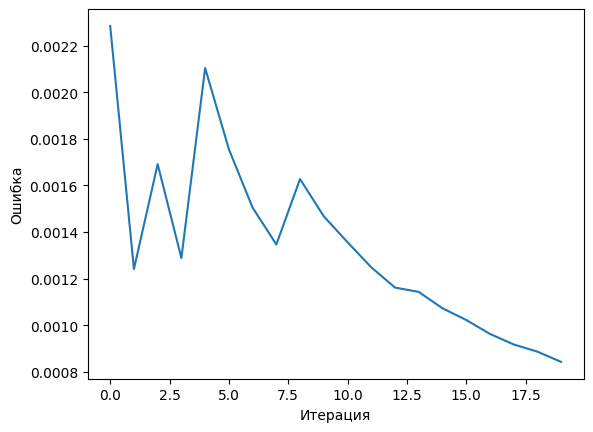

In [74]:
import matplotlib.pyplot as plt

plt.xlabel("Итерация")
plt.ylabel("Ошибка")
plt.plot(errors)
plt.savefig("risk_graph.png", dpi=300)
plt.show()

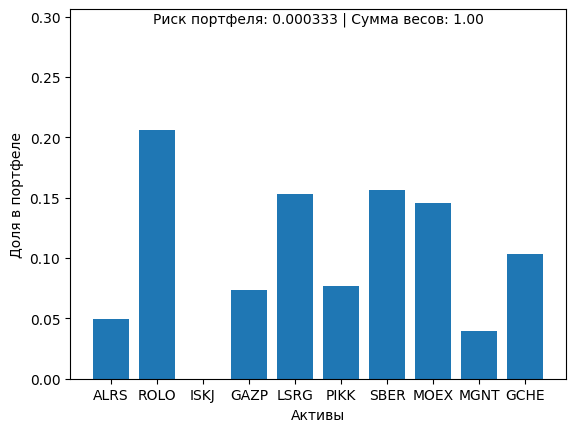

In [75]:

# График 2: веса x
plt.bar(data.columns, x)
plt.ylabel('Доля в портфеле')
plt.xlabel('Активы')
plt.ylim(0, max(x) + 0.1)

# Общая аннотация
plt.title(f'Риск портфеля: {np.dot(np.dot(test_cov,x),x):.6f} | Сумма весов: {x.sum():.2f}', fontsize=10, y=0.94)

plt.savefig("portfolio_risk.png", dpi=300)
plt.show()